## render GIF

In [1]:
# import imageio
# import os

In [2]:
# image = []
# for im in os.listdir('../results/'):
#     if im[-3:] == 'png':
#         image.append(im)
# image.sort()

In [3]:
# images = []
# for im in image:
#     images.append(imageio.imread('../results/'+im))
    
# imageio.mimsave('../results/score.gif', images, fps=1)

## simulated vs real tracks

In [4]:
import numpy as np
import pandas as pd
from scipy.interpolate import  splrep, splev
import scipy.stats as st

from utils.tools import *

In [5]:
import torch
from torch import nn

class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.ConvTranspose1d(8, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )

    def forward(self, z):    
        out = self.cnn(z)

        return out
    


class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(8, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.cnn(x)
        return out.squeeze(1)

In [6]:
generator_SD = torch.load('../results/SD_200_steps_G.pt', map_location=torch.device('cpu'))
generator_SV = torch.load('../results/SV_200_steps_G.pt', map_location=torch.device('cpu'))


nb = 100

z = torch.randn((nb, 256, 1))
traj_GAN_SD = generator_SD(z).detach().numpy()
traj_GAN_SV = generator_SV(z).detach().numpy()

In [7]:
data_GAN_SD = format_simulation(traj_GAN_SD, (-32.392, -3.819),  2e5)
data_GAN_SV = format_simulation(traj_GAN_SV, (-77.264, -11.773), 5e4)

In [8]:
data_GAN_SD = data_GAN_SD[data_GAN_SD.dist_colony > 1000]
data_GAN_SV = data_GAN_SV[data_GAN_SV.dist_colony > 1000]

In [116]:
simHMM_raw = pd.read_table("/home/amdroy/MEGA/SCRIPT/BirdGAN/results/sim_HMM_SD.csv", sep =',')

colony = (-32.392, -3.819)
simHMM_raw['lon'] = simHMM_raw.x * 180/np.pi/6371 + colony[0]
simHMM_raw['lat'] = simHMM_raw.y * 180/np.pi/6371 + colony[1]
simHMM_raw['trip'] = simHMM_raw.ID

simHMM = pd.DataFrame()

for t in simHMM_raw.trip.unique():
    traj = simHMM_raw[simHMM_raw.trip == t].copy()
    if sum((traj['colony.dist'] < 1) & (traj.states == 4)) > 1:
        i =  min(np.where((traj['colony.dist'] < 2) & (traj.states == 4))[0])
        traj = traj.iloc[:i+1]
        simHMM = simHMM.append(traj, ignore_index=True)

data_HMM_SD = format_data(simHMM, colony, 2e5)
data_HMM_SD = data_HMM_SD[data_HMM_SD.dist_colony > 1000]

traj_HMM_SD = padding_data(data_HMM_SD, 200)

In [117]:
simHMM_raw = pd.read_table("/home/amdroy/MEGA/SCRIPT/BirdGAN/results/sim_HMM_SV.csv", sep =',')

colony = (-77.264, -11.773)
simHMM_raw['lon'] = simHMM_raw.x * 180/np.pi/6371 + colony[0]
simHMM_raw['lat'] = simHMM_raw.y * 180/np.pi/6371 + colony[1]
simHMM_raw['trip'] = simHMM_raw.ID

simHMM = pd.DataFrame()

for t in simHMM_raw.trip.unique():
    traj = simHMM_raw[simHMM_raw.trip == t].copy()
    if sum((traj['colony.dist'] < 1) & (traj.states == 3)) > 1:
        i =  min(np.where((traj['colony.dist'] < 2) & (traj.states == 3))[0])
        traj = traj.iloc[:i+1]
        simHMM = simHMM.append(traj, ignore_index=True)

data_HMM_SV = format_data(simHMM, colony, 5e4)
data_HMM_SV = data_HMM_SV[data_HMM_SV.dist_colony > 1000]

traj_HMM_SV = padding_data(data_HMM_SV, 200)

In [118]:
# looping trajectories
len(data_HMM_SV.ID.unique())/100
len(data_HMM_SD.ID.unique())/100

0.94

In [119]:
data = pd.read_table('/home/amdroy/MEGA/SCRIPT/BirdGAN/data/trips_SD_200_steps.csv', sep = ',')
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

colony = (-32.392, -3.819)
data = format_data(data, colony, 2e5)
data_SD = data[data.dist_colony > 1000]

traj_SD = padding_data(data_SD, 200)

In [120]:
data = pd.read_table('/home/amdroy/MEGA/SCRIPT/BirdGAN/data/trips_SV_200_steps.csv', sep = ',')
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

colony = (-77.264, -11.773)
data = format_data(data, colony, 5e4)
data_SV = data[data.dist_colony > 1000]

traj_SV = padding_data(data_SV, 200)

### maps

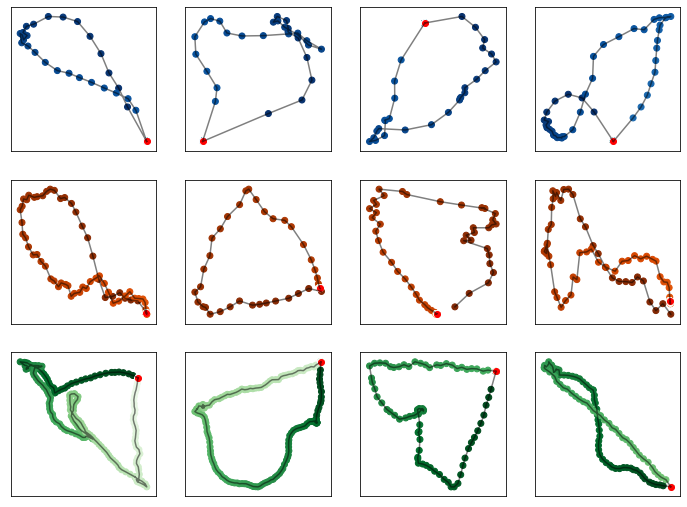

In [121]:
plt.figure(figsize=(12,9))

nb = [1, 4, 15, 40]
traj_sim = traj_SV
k = 1
for i in nb:
    plt.subplot(3,4,k)
    plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Blues_r')
    plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    plt.ylabel('Real')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    k+=1


nb = [1, 2, 3, 7]
traj_sim = traj_GAN_SV
k=1
for i in nb:
    plt.subplot(3,4,k+4)
    plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Oranges_r')
    plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    plt.ylabel('GAN')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    k+=1

nb = [5, 2, 3, 10]
traj_sim = traj_HMM_SV
k=1
for i in nb:
    plt.subplot(3,4,k+8)
    plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Greens_r')
    plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    plt.ylabel('HMM')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    k+=1

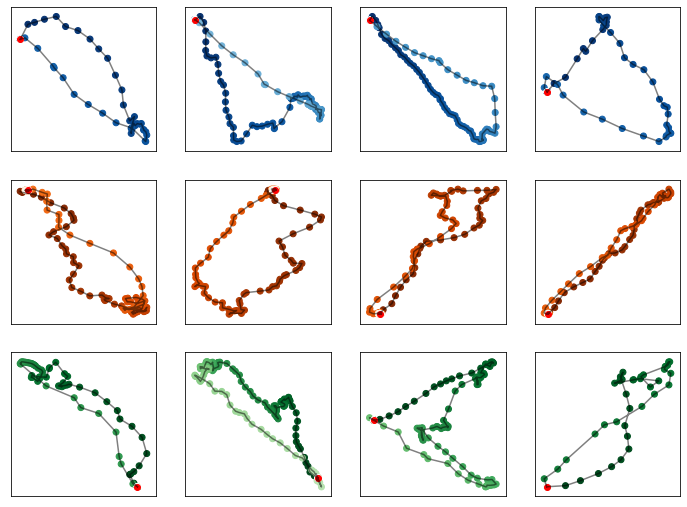

In [122]:
plt.figure(figsize=(12,9))

nb = [1, 20, 7, 12]
traj_sim = traj_SD
k = 1
for i in nb:
    plt.subplot(3,4,k)
    plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Blues_r')
    plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    plt.ylabel('Real')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    k+=1


nb = [1, 2, 3, 4]
traj_sim = traj_GAN_SD
k=1
for i in nb:
    plt.subplot(3,4,k+4)
    plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Oranges_r')
    plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    plt.ylabel('GAN')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    k+=1

nb = [5, 2, 3, 4]
traj_sim = traj_HMM_SD
k=1
for i in nb:
    plt.subplot(3,4,k+8)
    plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Greens_r')
    plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    plt.ylabel('HMM')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    k+=1

In [14]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import matplotlib.markers as mk
from netCDF4 import Dataset

In [15]:
dicolour = { 'blue':   '#1f77b4',  # muted blue
             'orange': '#ff7f0e',  # safety orange
             'green':  '#2ca02c',  # cooked asparagus green
             'red':    '#d62728',  # brick red
             'purple': '#9467bd',  # muted purple
             'brown':  '#8c564b',  # chestnut brown
             'pink':   '#e377c2',  # raspberry     yogurt pink
             'gray':   '#7f7f7f',  # middle gray
             'yellow': '#bcbd22'   # curry yellow-green
           }

Text(0.5, 1.0, 'HMM')

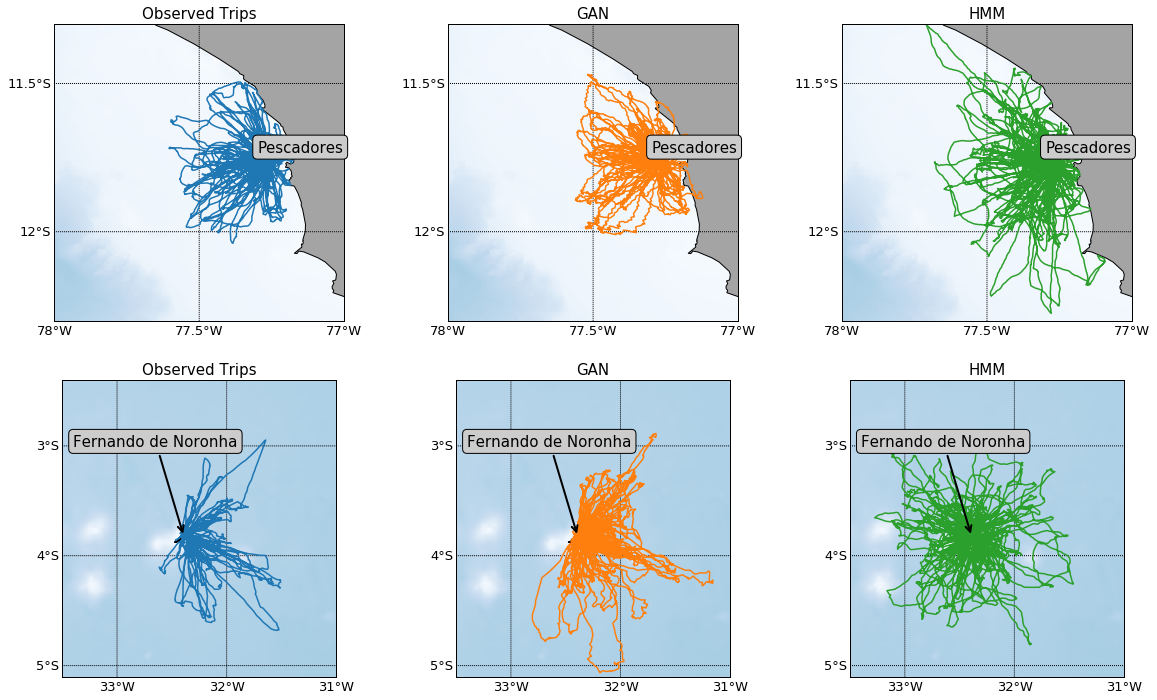

In [35]:
plt.figure(figsize=(20,12))

A1 = (-78, -77, -12.3, -11.3)
long_min, long_max = A1[0], A1[1]
lat_min, lat_max = A1[2], A1[3]

lon = data_SV.lon[data_SV.trip.isin(data_SV.trip.unique())]
lat = data_SV.lat[data_SV.trip.isin(data_SV.trip.unique())]
nb = len(data_SV.trip.unique())

plt.subplot(2,3,1)
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')
# meridians and parallels
parallels = np.arange(-15,-5,0.5)
meridians = np.arange(-80,-75,0.5)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)
# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_pescadores.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -6000, vmax=100)    
# trips
x, y = m(lon.values, lat.values)
m.plot(x, y, alpha= 1, color = dicolour['blue'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])
## colony
x, y = m(-77.264, -11.773)
m.scatter(x, y, marker = 's', s = 50, color = 'black', alpha= 1)
xt, yt = m(-77.3, -11.73)
plt.annotate('Pescadores', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
             bbox = dict(boxstyle="round", fc="0.8"))
plt.title('Observed Trips', fontsize = 15)


lon = data_GAN_SV.lon[data_GAN_SV.trip.isin(data_GAN_SV.trip.unique())]
lat = data_GAN_SV.lat[data_GAN_SV.trip.isin(data_GAN_SV.trip.unique())]
plt.subplot(2,3,2)
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')
# meridians and parallels
parallels = np.arange(-15,-5,0.5)
meridians = np.arange(-80,-75,0.5)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)
# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_pescadores.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -6000, vmax=100)    
# trips
x, y = m(lon.values, lat.values)
m.plot(x, y, alpha= 1, color = dicolour['orange'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])
## colony
x, y = m(-77.264, -11.773)
m.scatter(x, y, marker = 's', s = 50, color = 'black', alpha= 1)
xt, yt = m(-77.3, -11.73)
plt.annotate('Pescadores', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
             bbox = dict(boxstyle="round", fc="0.8"))
plt.title('GAN', fontsize = 15)


lon = data_HMM_SV.lon[data_HMM_SV.trip.isin(data_HMM_SV.trip.unique())]
lat = data_HMM_SV.lat[data_HMM_SV.trip.isin(data_HMM_SV.trip.unique())]
plt.subplot(2,3,3)
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')
# meridians and parallels
parallels = np.arange(-15,-5,0.5)
meridians = np.arange(-80,-75,0.5)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)
# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_pescadores.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -6000, vmax=100)    
# trips
x, y = m(lon.values, lat.values)
m.plot(x, y, alpha= 1, color = dicolour['green'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])
## colony
x, y = m(-77.264, -11.773)
m.scatter(x, y, marker = 's', s = 50, color = 'black', alpha= 1)
xt, yt = m(-77.3, -11.73)
plt.annotate('Pescadores', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
             bbox = dict(boxstyle="round", fc="0.8"))
# # map scale
# m.drawmapscale(-77.85, -12.35, -77.264, -11.773, 50, barstyle='fancy', fontsize = 13)
plt.title('HMM', fontsize = 15)



A1 = (-33.5, -31, -5.1, -2.4)
long_min, long_max = A1[0], A1[1]
lat_min, lat_max = A1[2], A1[3]

lon = data_SD.lon[data_SD.trip.isin(data_SD.trip.unique())]
lat = data_SD.lat[data_SD.trip.isin(data_SD.trip.unique())]
nb = len(data_SD.trip.unique())

plt.subplot(2,3,4)
ax = plt.gca()
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )

# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')
m.readshapefile('/home/amdroy/MEGA/DATA/SHAPEFILE/Fernando/Fernandho_OSM_NE', 'Fernandho_OSM_NE',drawbounds=False)
patches   = []
for info, shape in zip(m.Fernandho_OSM_NE_info, m.Fernandho_OSM_NE):
    patches.append( Polygon(np.array(shape), True) )       
ax.add_collection(PatchCollection(patches, facecolor= 'k', edgecolor='k', linewidths=1., zorder=2))
# meridians and parallels
parallels = np.arange(-15,0,1)
meridians = np.arange(-40,-20,1)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)
# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_fernando.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -15000, vmax=500)
# trips
x, y = m(lon.values, lat.values)
m.plot(x, y, alpha= 1, color = dicolour['blue'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])
## colony
x, y = m(-32.392, -3.819)
# m.scatter(x, y, marker = 's', s = 50, color = 'black', alpha= 1)
xt, yt = m(-33.4, -3)
plt.annotate('Fernando de Noronha', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops = dict(arrowstyle = '->', color = 'k', lw = 2))
plt.title('Observed Trips', fontsize = 15)


lon = data_GAN_SD.lon[data_GAN_SD.trip.isin(data_GAN_SD.trip.unique())]
lat = data_GAN_SD.lat[data_GAN_SD.trip.isin(data_GAN_SD.trip.unique())]
nb = len(data_GAN_SD.trip.unique())

plt.subplot(2,3,5)
ax = plt.gca()
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )

# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')
m.readshapefile('/home/amdroy/MEGA/DATA/SHAPEFILE/Fernando/Fernandho_OSM_NE', 'Fernandho_OSM_NE',drawbounds=False)
patches   = []
for info, shape in zip(m.Fernandho_OSM_NE_info, m.Fernandho_OSM_NE):
    patches.append( Polygon(np.array(shape), True) )       
ax.add_collection(PatchCollection(patches, facecolor= 'k', edgecolor='k', linewidths=1., zorder=2))
# meridians and parallels
parallels = np.arange(-15,0,1)
meridians = np.arange(-40,-20,1)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)
# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_fernando.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -15000, vmax=500)
# trips
x, y = m(lon.values, lat.values)
m.plot(x, y, alpha= 1, color = dicolour['orange'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])
## colony
x, y = m(-32.392, -3.819)
# m.scatter(x, y, marker = 's', s = 50, color = 'black', alpha= 1)
xt, yt = m(-33.4, -3)
plt.annotate('Fernando de Noronha', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops = dict(arrowstyle = '->', color = 'k', lw = 2))
plt.title('GAN', fontsize = 15)


lon = data_HMM_SD.lon[data_HMM_SD.trip.isin(data_HMM_SD.trip.unique())]
lat = data_HMM_SD.lat[data_HMM_SD.trip.isin(data_HMM_SD.trip.unique())]
nb = len(data_HMM_SD.trip.unique())

plt.subplot(2,3,6)
ax = plt.gca()
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )

# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')
m.readshapefile('/home/amdroy/MEGA/DATA/SHAPEFILE/Fernando/Fernandho_OSM_NE', 'Fernandho_OSM_NE',drawbounds=False)
patches   = []
for info, shape in zip(m.Fernandho_OSM_NE_info, m.Fernandho_OSM_NE):
    patches.append( Polygon(np.array(shape), True) )       
ax.add_collection(PatchCollection(patches, facecolor= 'k', edgecolor='k', linewidths=1., zorder=2))
# meridians and parallels
parallels = np.arange(-15,0,1)
meridians = np.arange(-40,-20,1)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)
# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_fernando.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -15000, vmax=500)
# trips
x, y = m(lon.values, lat.values)
m.plot(x, y, alpha= 1, color = dicolour['green'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])
## colony
x, y = m(-32.392, -3.819)
# m.scatter(x, y, marker = 's', s = 50, color = 'black', alpha= 1)
xt, yt = m(-33.4, -3)
plt.annotate('Fernando de Noronha', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops = dict(arrowstyle = '->', color = 'k', lw = 2))
plt.title('HMM', fontsize = 15)

In [17]:
def get_mean_dist(data):
    var = []
    for tt in data.trip.unique():
        traj = data[data.trip == tt].copy()
        
        lon = np.array([traj.lon.values for i in range(len(traj))])
        lat = np.array([traj.lat.values for i in range(len(traj))])
        
        d = dist_ortho(lon, lat, lon.T, lat.T)
        
        var.append(np.mean(np.sum(d < 500, axis = 1)))
        
    return np.array(var)

Text(0.5, 1.0, 'Step Direction (degree)')

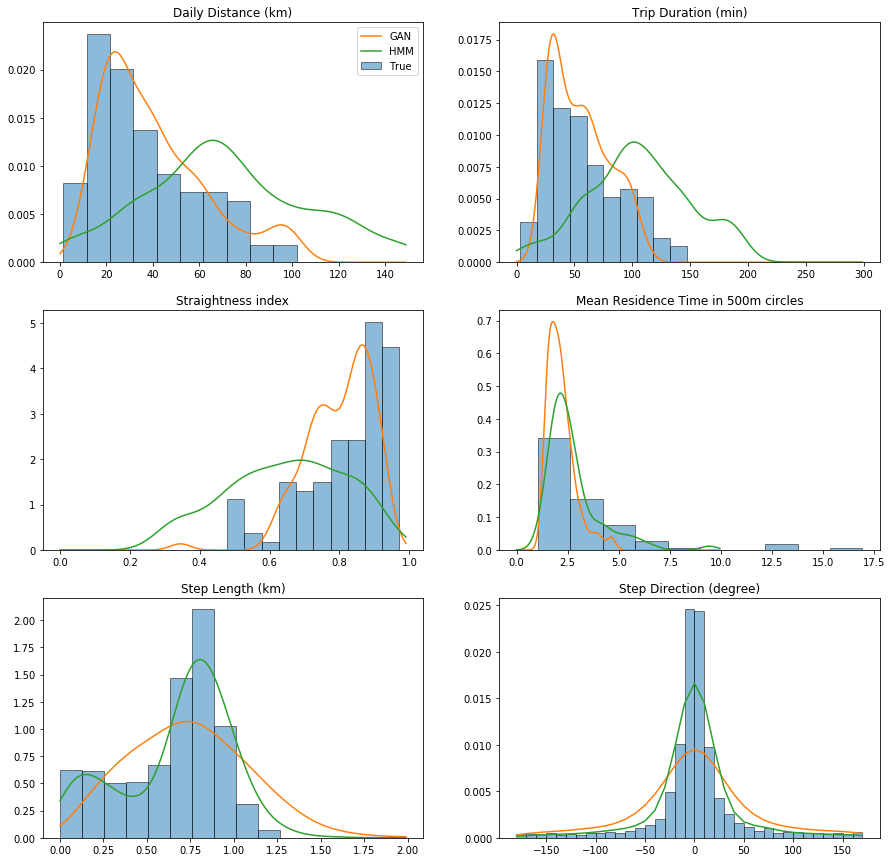

In [18]:
data = data_SV
simGAN = data_GAN_SV
simHMM = data_HMM_SV

plt.figure(figsize = (15,15))

plt.subplot(3,2,1)
## DAILY DISTANCE
y = get_trip_dist(data)

y_GAN = get_trip_dist(simGAN)
y_HMM = get_trip_dist(simHMM)
dy_GAN = kde1d(y_GAN/1e3, bw = 0.3)
dy_HMM = kde1d(y_HMM/1e3, bw = 0.3)

bins = np.arange(0, 150, 10)
# plt.hist(y/1e3, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['blue'], label = 'True')
# plt.hist(y_false/1e3, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['orange'], label = 'Simulation')
x = np.arange(0,150, 1)
plt.hist(y/1e3, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.legend()
plt.title('Daily Distance (km)')

plt.subplot(3,2,2)
## FORAGING DURATION
y = get_trip_duration(data)
y_GAN = get_trip_duration(simGAN)
y_HMM = get_trip_duration(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.3)
dy_HMM = kde1d(y_HMM, bw = 0.3)

bins = np.arange(0, 300, 15)
# plt.hist(y, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['blue'], label = 'True')
# plt.hist(y_false, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['orange'], label = 'Simulation')

x = np.arange(0,300, 1)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Trip Duration (min)')

plt.subplot(3,2,3)
# STRAIGHTNESS INDEX
y = get_trip_sinuosity(data)
y_GAN = get_trip_sinuosity(simGAN)
y_HMM = get_trip_sinuosity(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.3)
dy_HMM = kde1d(y_HMM, bw = 0.3)

x = np.arange(0,1, 0.01)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Straightness index')


plt.subplot(3,2,4)
# MEAN residence time in 500m radius 
y = get_mean_dist(data)
y_GAN = get_mean_dist(simGAN)
y_HMM = get_mean_dist(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.3)
dy_HMM = kde1d(y_HMM, bw = 0.3)

x = np.arange(0,10, 0.05)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Mean Residence Time in 500m circles')


plt.subplot(3,2,5)
# STEP LENGTH
y_GAN = simGAN.step_distance/1e3
y_HMM = simHMM.step_distance/1e3
dy_GAN = kde1d(y_GAN.dropna(), bw = 0.3)
dy_HMM = kde1d(y_HMM.dropna(), bw = 0.3)

x = np.arange(0,2, 0.01)
plt.hist(data.step_distance.dropna()/1e3, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Step Length (km)')

plt.subplot(3,2,6)
# STEP DIRECTION
y_GAN = simGAN.step_direction
y_HMM = simHMM.step_direction
dy_GAN = kde1d(y_GAN.dropna(), bw = 0.3)
dy_HMM = kde1d(y_HMM.dropna(), bw = 0.3)

x = np.arange(-180,180, 10)
plt.hist(data.step_direction, bins = x, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Step Direction (degree)')
# score_foraging_times = np.sum((dy_false/np.sum(dy_false) - dy/np.sum(dy))**2) / np.sum( (dy/np.sum(dy))**2)

#     return  [score_daily_dist, score_foraging_duration]

Text(0.5, 1.0, 'Step Direction (degree)')

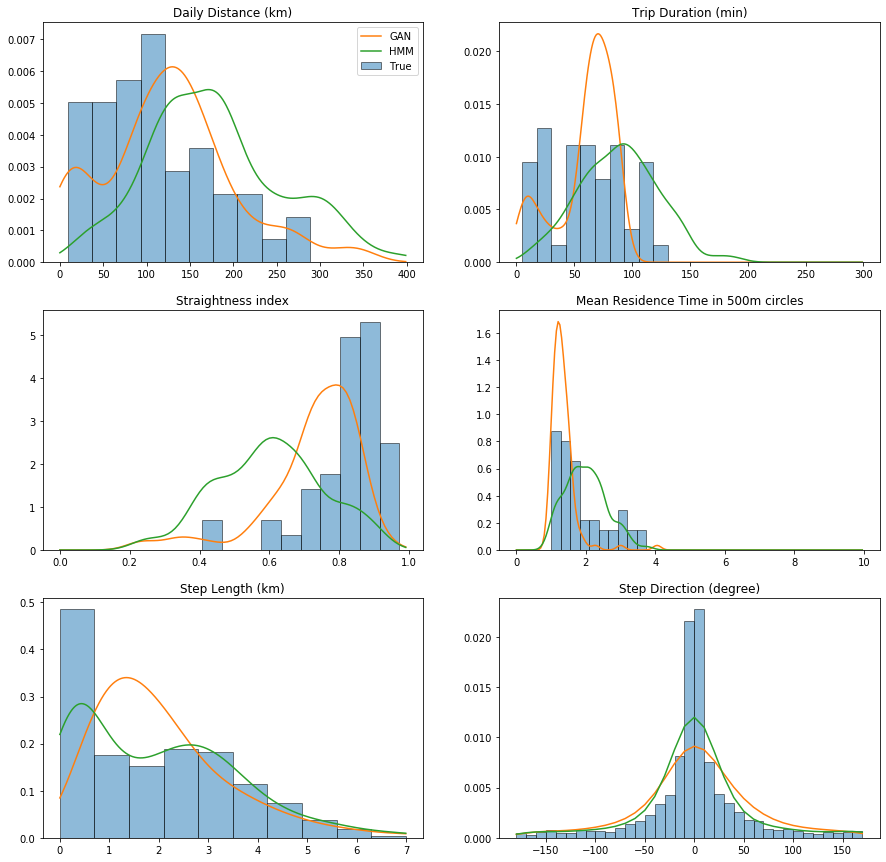

In [19]:
data = data_SD
simGAN = data_GAN_SD
simHMM = data_HMM_SD

plt.figure(figsize = (15,15))

plt.subplot(3,2,1)
## DAILY DISTANCE
y = get_trip_dist(data)

y_GAN = get_trip_dist(simGAN)
y_HMM = get_trip_dist(simHMM)
dy_GAN = kde1d(y_GAN/1e3, bw = 0.3)
dy_HMM = kde1d(y_HMM/1e3, bw = 0.3)

bins = np.arange(0, 400, 10)
# plt.hist(y/1e3, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['blue'], label = 'True')
# plt.hist(y_false/1e3, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['orange'], label = 'Simulation')
x = np.arange(0,400, 1)
plt.hist(y/1e3, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.legend()
plt.title('Daily Distance (km)')

plt.subplot(3,2,2)
## FORAGING DURATION
y = get_trip_duration(data)
y_GAN = get_trip_duration(simGAN)
y_HMM = get_trip_duration(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.3)
dy_HMM = kde1d(y_HMM, bw = 0.3)

bins = np.arange(0, 300, 15)
# plt.hist(y, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['blue'], label = 'True')
# plt.hist(y_false, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['orange'], label = 'Simulation')

x = np.arange(0,300, 1)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Trip Duration (min)')

plt.subplot(3,2,3)
# STRAIGHTNESS INDEX
y = get_trip_sinuosity(data)
y_GAN = get_trip_sinuosity(simGAN)
y_HMM = get_trip_sinuosity(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.3)
dy_HMM = kde1d(y_HMM, bw = 0.3)

x = np.arange(0,1, 0.01)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Straightness index')


plt.subplot(3,2,4)
# MEAN residence time in 500m radius 
y = get_mean_dist(data)
y_GAN = get_mean_dist(simGAN)
y_HMM = get_mean_dist(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.3)
dy_HMM = kde1d(y_HMM, bw = 0.3)

x = np.arange(0,10, 0.05)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Mean Residence Time in 500m circles')


plt.subplot(3,2,5)
# STEP LENGTH
y_GAN = simGAN.step_distance/1e3
y_HMM = simHMM.step_distance/1e3
dy_GAN = kde1d(y_GAN.dropna(), bw = 0.3)
dy_HMM = kde1d(y_HMM.dropna(), bw = 0.3)

x = np.arange(0,7, 0.01)
plt.hist(data.step_distance.dropna()/1e3, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Step Length (km)')

plt.subplot(3,2,6)
# STEP DIRECTION
y_GAN = simGAN.step_direction
y_HMM = simHMM.step_direction
dy_GAN = kde1d(y_GAN.dropna(), bw = 0.3)
dy_HMM = kde1d(y_HMM.dropna(), bw = 0.3)

x = np.arange(-180,180, 10)
plt.hist(data.step_direction, bins = x, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Step Direction (degree)')
# score_foraging_times = np.sum((dy_false/np.sum(dy_false) - dy/np.sum(dy))**2) / np.sum( (dy/np.sum(dy))**2)

#     return  [score_daily_dist, score_foraging_duration]

In [20]:
import scipy.signal

In [21]:
def get_periodogram(traj):    
    periodogram_lon = []
    periodogram_lat = []

    for j in range(traj.shape[0]):
        lon = traj[j, 0, :]
        lat = traj[j, 1, :]
        x, lon = scipy.signal.periodogram(lon, scaling = 'spectrum', detrend = False)
        x, lat = scipy.signal.periodogram(lat, scaling = 'spectrum', detrend = False)
        
        periodogram_lon.append(lon)
        periodogram_lat.append(lat)
        
    return (x, np.array(periodogram_lon), np.array(periodogram_lat))
    

In [22]:
x, lon, lat = get_periodogram(traj_SV)
x, lon_GAN, lat_GAN = get_periodogram(traj_GAN_SV)
x, lon_HMM, lat_HMM = get_periodogram(traj_HMM_SV)

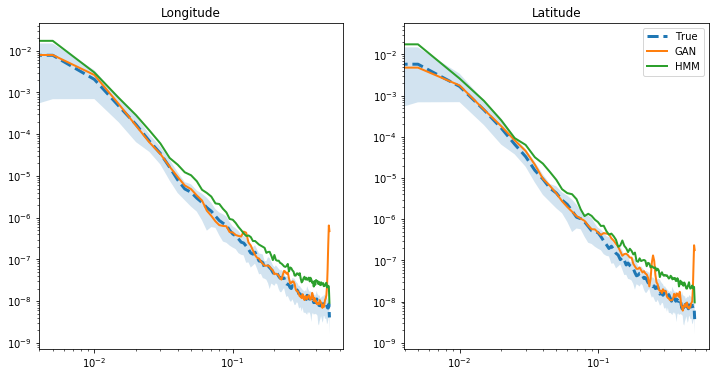

In [23]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
plt.loglog(x, np.mean(lon, axis=0), linewidth = 3, linestyle = '--')
plt.fill_between(x, np.mean(lon, axis=0) - 0.5 * np.std(lon, axis=0) ,  
                 np.mean(lon, axis=0) + 0.5 * np.std(lon, axis=0),
                alpha = 0.2)


plt.loglog(x, np.mean(lon_GAN, axis=0), linewidth = 2)
# plt.fill_between(x, np.mean(lon_GAN, axis=0) - 0.5 * np.std(lon_GAN, axis=0) ,  
#                  np.mean(lon_GAN, axis=0) + 0.5 * np.std(lon_GAN, axis=0),
#                  alpha = 0.2)

plt.loglog(x, np.mean(lon_HMM, axis=0), linewidth = 2)
# plt.fill_between(x, np.mean(lon_HMM, axis=0) - 0.5 * np.std(lon_HMM, axis=0) ,  
#                  np.mean(lon_HMM, axis=0) + 0.5 * np.std(lon_HMM, axis=0),
#                  alpha = 0.2)

# plt.xlim([0.005, 0.5])
# plt.ylim([1e-6, 1e1])
plt.title('Longitude')

plt.subplot(1,2,2)
plt.loglog(x, np.mean(lat, axis=0), linewidth = 3, linestyle = '--', label = 'True')
plt.fill_between(x, np.mean(lon, axis=0) - 0.5 * np.std(lon, axis=0) ,  
                 np.mean(lon, axis=0) + 0.5 * np.std(lon, axis=0),
                alpha = 0.2)

plt.loglog(x, np.mean(lat_GAN, axis=0), linewidth = 2, label = 'GAN')
# plt.fill_between(x, np.mean(lat_GAN, axis=0) - 0.5 * np.std(lat_GAN, axis=0) ,  
#                  np.mean(lat_GAN, axis=0) + 0.5 * np.std(lat_GAN, axis=0),
#                  alpha = 0.2)

plt.loglog(x, np.mean(lat_HMM, axis=0), linewidth = 2, label = 'HMM')
# plt.fill_between(x, np.mean(lat_HMM, axis=0) - 0.5 * np.std(lat_HMM, axis=0) ,  
#                  np.mean(lat_HMM, axis=0) + 0.5 * np.std(lat_HMM, axis=0),
#                  alpha = 0.2)

# plt.xlim([0, 0.5])
# plt.ylim([1e-6, 1e1])
plt.legend()
plt.title('Latitude')

plt.show()

In [24]:
x, lon, lat = get_periodogram(traj_SD)
x, lon_GAN, lat_GAN = get_periodogram(traj_GAN_SD)
x, lon_HMM, lat_HMM = get_periodogram(traj_HMM_SD)

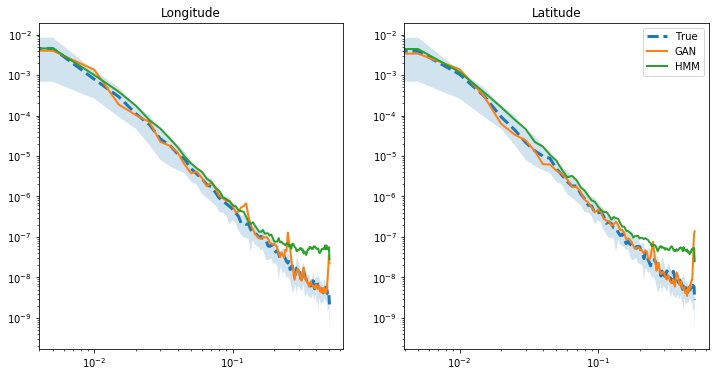

In [25]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
plt.loglog(x, np.mean(lon, axis=0), linewidth = 3, linestyle = '--')
plt.fill_between(x, np.mean(lon, axis=0) - 0.5 * np.std(lon, axis=0) ,  
                 np.mean(lon, axis=0) + 0.5 * np.std(lon, axis=0),
                alpha = 0.2)


plt.loglog(x, np.mean(lon_GAN, axis=0), linewidth = 2)
# plt.fill_between(x, np.mean(lon_GAN, axis=0) - 0.5 * np.std(lon_GAN, axis=0) ,  
#                  np.mean(lon_GAN, axis=0) + 0.5 * np.std(lon_GAN, axis=0),
#                  alpha = 0.2)

plt.loglog(x, np.mean(lon_HMM, axis=0), linewidth = 2)
# plt.fill_between(x, np.mean(lon_HMM, axis=0) - 0.5 * np.std(lon_HMM, axis=0) ,  
#                  np.mean(lon_HMM, axis=0) + 0.5 * np.std(lon_HMM, axis=0),
#                  alpha = 0.2)

# plt.xlim([0.005, 0.5])
# plt.ylim([1e-6, 1e1])
plt.title('Longitude')

plt.subplot(1,2,2)
plt.loglog(x, np.mean(lat, axis=0), linewidth = 3, linestyle = '--', label = 'True')
plt.fill_between(x, np.mean(lon, axis=0) - 0.5 * np.std(lon, axis=0) ,  
                 np.mean(lon, axis=0) + 0.5 * np.std(lon, axis=0),
                alpha = 0.2)

plt.loglog(x, np.mean(lat_GAN, axis=0), linewidth = 2, label = 'GAN')
# plt.fill_between(x, np.mean(lat_GAN, axis=0) - 0.5 * np.std(lat_GAN, axis=0) ,  
#                  np.mean(lat_GAN, axis=0) + 0.5 * np.std(lat_GAN, axis=0),
#                  alpha = 0.2)

plt.loglog(x, np.mean(lat_HMM, axis=0), linewidth = 2, label = 'HMM')
# plt.fill_between(x, np.mean(lat_HMM, axis=0) - 0.5 * np.std(lat_HMM, axis=0) ,  
#                  np.mean(lat_HMM, axis=0) + 0.5 * np.std(lat_HMM, axis=0),
#                  alpha = 0.2)

# plt.xlim([0, 0.5])
# plt.ylim([1e-6, 1e1])
plt.legend()
plt.title('Latitude')

plt.show()